# 지오코딩 결과 시각화 & Matplotlib/Seaborn/Plotly/Altair 종합 예제

이 노트북은 프로젝트에서 생성된 지오코딩 결과(`outputs/주택정비형_geocoded_full.csv`)를 간단히 시각화한 뒤, 다양한 Python 시각화 기법(Matplotlib, Seaborn, Plotly, Altair, ipywidgets 등)을 종합적으로 정리합니다.

구성 개요:
- 지오코딩 포인트 지도 (경계/타일 옵션 포함)
- 기본 선/산점/분포/카테고리/시계열/상관/인터랙티브/애니메이션
- 스타일, 폰트(한글), 이중축, 저장, Jupytext 연계

필요 패키지(일부 선택): `pandas`, `numpy`, `matplotlib`, `seaborn`, `plotly`, `altair`, `ipywidgets`, `geopandas`, `contextily`

## 지오코딩 결과 간단 확인 및 포인트 시각화
가벼운 형태로 `outputs/주택정비형_geocoded.csv` 를 읽고 좌표 산점도를 그립니다. (열: lat, lon, success)

## 데이터 구조 & 컬럼 유지 전략 (요약)

이 노트북은 두 가지 핵심 데이터셋을 전제로 합니다.

1. 전체 사업장(Master): append-latlon 또는 full-output 결과 (예: `*_geocoded_enriched.csv`)
2. 신속통합기획 Subset: Master에서 `신속통합기획` 값 존재 행 필터 (`syn_df`)

### 핵심 컬럼 그룹
- 위치 원천: `정비구역위치`, `자치구`, `법정동`, `대표지번`
- 진행/단계: `진행단계`, `진행단계_구간` (있으면 후자가 우선)
- 식별자: `사업번호` (없으면 index 기반 surrogate)
- 파생 지오코딩: `lat`, `lon`, (디버그) `geocode_status`, `geocode_tag`, `geocode_query`, `success`
- 분산 표시: `jitter_applied`, 원본좌표 보존: `lat_raw`, `lon_raw`

### 지오코딩 실행 모드 (scripts/geocode_location_priority.py)
| 모드 | 사용 목적 | 포함 |
|------|-----------|------|
| 기본(minimal) | 단순 좌표만 필요 | lat, lon, success |
| --append-latlon | 원본 유지 + 좌표만 추가 | 원본 + lat, lon |
| --full-output | 정밀/디버그 분석 | 원본 + geocode_* + lat/lon |
| --debug-out | append 사용 중 디버그 별도 저장 | full과 유사 별도 파일 |

추가 옵션: `--prefer-lot-first`, `--refine-coarse --max-refine N`, `--dedupe-jitter --jitter-radius r`

### 파생 & Subset 규칙
- Subset 생성은 “행 필터”만 (컬럼 드롭 금지)
- 단계 컬럼 선택 로직: `진행단계_구간` 존재 → 사용, 아니면 `진행단계`
- 중복 좌표 시각적 해결: jitter 적용 (실제 정밀 분석 시 `lat_raw` 사용)

### 무결성 체크 (Notebook 진입 시 권장)
1. 행 수/컬럼 존재: 로더 출력 확인
2. 진행단계 감사 셀(Audit) 실행 → Null/빠진 값 검사
3. 중복 좌표 다수면 refine + lot-first 재실행 고려
4. syn_df 필터 후 컬럼 손실 없는지 (head/columns 비교)

### 파일 네이밍 권장
```
<주제>_geocoded_<YYYYMMDD_HHMM>.csv
<주제>_geocoded_enriched.csv         # 대표본
<주제>_geocoded_debug.csv            # 디버그(옵션)
<주제>_syn_filtered.csv              # 신속통합 subset
```

> 상세한 전체 전략은 README의 "데이터 구조 & 컬럼 유지 전략" 섹션 참조.


In [46]:
# CSV 경로 (append-latlon + jitter 적용된 최신 enriched 파일 경로)
csv_path = '/Users/cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/outputs/주택정비형_신통_geocoded_enriched.csv'

import pandas as pd, os, textwrap

if not os.path.exists(csv_path):
    raise SystemExit(f'[ERROR] 파일을 찾을 수 없습니다: {csv_path}')

df_geo = pd.read_csv(csv_path)
print(f'[LOAD] df_geo rows={len(df_geo)}, cols={len(df_geo.columns)}')
print('[LOAD] columns:', list(df_geo.columns)[:15], '...')

# lat/lon 필드 탐색 (lat_raw/lon_raw 있는 경우 우선 설명)
lat_col = 'lat' if 'lat' in df_geo.columns else None
lon_col = 'lon' if 'lon' in df_geo.columns else None
if lat_col is None or lon_col is None:
    raise RuntimeError('lat/lon 컬럼을 찾지 못했습니다.')

# jitter 적용 여부 파악
ih_jitter = 'jitter_applied' in df_geo.columns
if ih_jitter:
    jitter_rate = df_geo['jitter_applied'].fillna(False).mean()
    print(f'[INFO] jitter_applied 컬럼 발견 -> 분산 적용 비율: {jitter_rate:.3f}')

# pts / geo_pts 생성을 위한 얕은 사본 (이후 셀과 호환)
pts = df_geo[['lon','lat']].copy()
print('[INFO] pts DataFrame 준비 완료')

# (옵션) 기본 통계
print('[BASIC] 좌표 결측률:', 1 - df_geo[['lat','lon']].notna().all(axis=1).mean())
print('[BASIC] 고유 좌표 수:', df_geo[['lat','lon']].drop_duplicates().shape[0])

[LOAD] df_geo rows=150, cols=40
[LOAD] columns: ['사업번호', '신속통합기획', '자치구', '법정동', '운영구분', '대표지번', '진행단계', '상태', '토지등 소유자 수', '정비구역명칭', '정비구역위치', '정비구역면적(㎡)', '건축연면적(㎡)', '용도지역', '용도지구'] ...
[INFO] pts DataFrame 준비 완료
[BASIC] 좌표 결측률: 0.0
[BASIC] 고유 좌표 수: 150


In [47]:
# (안전 로더) df_geo/pts/geo_pts 재구성 유틸 함수
import pandas as pd, geopandas as gpd
from shapely.geometry import Point

def ensure_geo_frames(df: pd.DataFrame):
    global pts, geo_pts
    if 'lon' not in df.columns or 'lat' not in df.columns:
        raise ValueError('lon/lat 컬럼이 필요합니다.')
    pts = df[['lon','lat']].dropna().copy()
    # 서울/국내 범위 필터 (단순 범위)
    pts_valid = pts[pts['lon'].between(124,132) & pts['lat'].between(33,39)].copy()
    if len(pts_valid) != len(pts):
        print(f"[ensure_geo_frames] 범위 밖 {len(pts)-len(pts_valid)}건 제외")
    geo_pts = gpd.GeoDataFrame(
        df.loc[pts_valid.index].copy(),
        geometry=[Point(xy) for xy in zip(pts_valid['lon'], pts_valid['lat'])],
        crs='EPSG:4326'
    )
    print(f"[ensure_geo_frames] geo_pts 생성: {len(geo_pts)} rows")

# 필요시 실행 (이미 pts/geo_pts 있으면 건너뛰기)
if 'geo_pts' not in globals():
    ensure_geo_frames(df_geo)
else:
    print('[ensure_geo_frames] 기존 geo_pts 유지')

[ensure_geo_frames] 기존 geo_pts 유지


### 행정동 경계 Shapefile 로드 및 서울특별시 경계 플롯
`DATA/LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11_202509.shp` 파일을 읽어 컬럼 패턴을 탐색하고, '서울특별시' 관련 행만 추출 후 경계를 표시합니다.

In [ ]:
# 경계 Shapefile 경로 (UMD 최신)
shp_path = '/Users/cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/DATA/raw/LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11_202509.shp'
print('[INFO] 사용 Shapefile:', shp_path)

[INFO] 사용 Shapefile: /Users/cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/DATA/LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11_202509.shp


In [49]:
# 자치구 / 진행단계(또는 진행단계_구간)별 사업장 개수 표 생성 (강화 버전)

# 후보 DataFrame 우선순위: geo_pts (전체 컬럼 보존) > df_geo > pts_valid > pts
candidates = []
for name in ['geo_pts','df_geo','pts_valid','pts']:
    if name in globals():
        candidates.append((name, globals()[name]))

if not candidates:
    raise RuntimeError('집계 대상 DataFrame 이 없습니다. 상단 로더/CRS 셀 실행 필요.')

# 단계 컬럼 존재 여부를 기준으로 최적 base 선택
preferred = None
for label, dfc in candidates:
    if any(col in dfc.columns for col in ['진행단계_구간','진행단계']):
        preferred = (label, dfc)
        break
if preferred is None:
    # 진단 출력
    print('[DIAG] 후보 DataFrame 목록 및 컬럼 수:')
    for label, dfc in candidates:
        print(f' - {label}: shape={dfc.shape} sample_cols={list(dfc.columns)[:10]}')
    raise RuntimeError('진행단계 관련 컬럼(진행단계_구간 / 진행단계)을 어떤 DataFrame에서도 찾지 못했습니다.')

base_name, base = preferred
print(f'[INFO] 집계 base DataFrame: {base_name} (shape={base.shape})')

# 단계 컬럼 결정
stage_col = '진행단계_구간' if '진행단계_구간' in base.columns else '진행단계'

# 자치구 존재 검사
if '자치구' not in base.columns:
    raise RuntimeError("'자치구' 컬럼이 base DataFrame에 없습니다.")

# 그룹 집계
pivot = (
    base
    .groupby(['자치구', stage_col])
    .size()
    .unstack(fill_value=0)
)

pivot['합계'] = pivot.sum(axis=1)
pivot = pivot.sort_values('합계', ascending=False)

# 단계 컬럼 순서 고정 시도
desired_order = ['계획단계','시행준비단계','시행단계','완료단계']
existing = [c for c in desired_order if c in pivot.columns]
others = [c for c in pivot.columns if c not in existing and c != '합계']
pivot = pivot[existing + others + ['합계']]

# Grand total
grand_total = pivot.sum(axis=0).to_frame().T
grand_total.index = ['전체합계']
result = pd.concat([pivot, grand_total])

print(f"[INFO] 단계컬럼='{stage_col}', distinct stages={len(pivot.columns)-1}")
print('[INFO] 자치구 / 단계별 건수')
display(result)

[INFO] 집계 base DataFrame: df_geo (shape=(150, 40))
[INFO] 단계컬럼='진행단계_구간', distinct stages=4
[INFO] 자치구 / 단계별 건수


진행단계_구간,계획단계,시행준비단계,시행단계,완료단계,합계
성북구,1,10,8,3,22
동대문구,0,5,8,5,18
동작구,0,2,11,1,14
서대문구,2,2,5,0,9
은평구,1,0,5,3,9
양천구,0,4,1,4,9
성동구,0,5,1,3,9
관악구,1,1,5,1,8
강북구,0,3,1,2,6
용산구,1,3,2,0,6


In [50]:
# 성북구 사업장 10개 샘플 출력
if 'df_geo' not in globals():
    raise RuntimeError("df_geo 데이터프레임이 없습니다. CSV 로드 셀을 먼저 실행하세요.")

col_needed = '자치구'
if col_needed not in df_geo.columns:
    raise RuntimeError(f"'{col_needed}' 컬럼이 없습니다. 컬럼 목록: {list(df_geo.columns)}")

sb = df_geo[df_geo[col_needed].astype(str) == '성북구'].copy()
count = len(sb)

cols = ['정비구역명칭', '정비구역위치', '진행단계','정비구역면적(㎡)','토지등 소유자 수']
missing = [c for c in cols if c not in sb.columns]
if missing:
    raise RuntimeError(f"누락 컬럼: {missing}")
sample = sb[cols].head(10).rename(columns={'토지등 소유자 수': '토지등소유자수'})
print(f"성북구 사업장 총 {count}건 중 상위 10건 (요청 컬럼만):")
display(sample)

성북구 사업장 총 22건 중 상위 10건 (요청 컬럼만):


,정비구역명칭,정비구역위치,진행단계,정비구역면적(㎡),토지등소유자수
19,하월곡1구역 주택정비형 재개발사업,성북구 하월곡동 70-1,정비구역지정,80699.0,624
86,보문제5구역 주택재개발정비사업,성북구 보문동1가 196-11번지,착공신고,10798.5,156
87,삼선제5주택재개발정비사업,성북구 삼선동2가 296번지,일반분양승인,63918.5,419
88,장위14구역 주택재개발정비사업조합,성북구 장위동 233-552번지,조합설립인가,145174.6,1427
89,장위3구역주택재개발정비사업조합,성북구 장위동 305일대,조합설립추진위원회승인,66011.0,392
90,보문제2구역 주택재개발정비사업,성북구26길 13-9(보문동1가),준공인가,17837.0,237
91,동선2구역주택재개발정비사업,동선동 304-2,관리처분인가,15608.2,166
92,성북제2구역주택재개발정비사업,성북동 226-103번지,사업시행인가,75072.8,361
93,돈암제6 주택재개발정비구역,성북구 돈암동 48-29,조합설립인가,43438.8,527
94,성북제1구역주택재개발정비사업조합설립추지위원회,성북1동 179-68번지,조합설립인가,127899.0,1192


In [51]:
# Shapefile 읽고 gdf_ok 정의 (이름 컬럼 패턴 확장: ADM_NM / ADMI_NM / EMD_NM / COL_ADM_SE)
import geopandas as gpd
from pathlib import Path

if 'gdf_ok' in globals():
    print('[INFO] 기존 gdf_ok 변수 이미 존재 -> 재생성')

shp_path_obj = Path(shp_path)
if not shp_path_obj.exists():
    raise FileNotFoundError(f'Shapefile 경로가 존재하지 않습니다: {shp_path_obj}')

print('[LOAD] GeoDataFrame 로드 중...')
gdf_raw = gpd.read_file(shp_path_obj)
print(f'[LOAD] 원본 행 수: {len(gdf_raw)}, 컬럼 수: {len(gdf_raw.columns)}')
print('[LOAD] 컬럼 목록:', list(gdf_raw.columns))

# CRS 처리
if gdf_raw.crs is None:
    print('[WARN] 원본 CRS 미지정 -> EPSG:5179(가정) 가능 (확신 없으면 그대로 둠)')
    # gdf_raw.set_crs(epsg=5179, inplace=True)

# WGS84 변환 (가능하면)
try:
    if gdf_raw.crs and gdf_raw.crs.to_epsg() != 4326:
        gdf_wgs = gdf_raw.to_crs(epsg=4326)
    else:
        gdf_wgs = gdf_raw
except Exception as e:
    print('[WARN] CRS 변환 실패 -> 그대로 사용:', e)
    gdf_wgs = gdf_raw

# 이름 컬럼 탐지 확장
preferred_order = ['ADM_NM','ADMI_NM','EMD_NM','COL_ADM_SE']
name_col = None
for c in preferred_order:
    if c in gdf_wgs.columns:
        name_col = c
        break
if name_col is None:
    # 패턴 탐색 (NM / NAME 포함 + 문자열 타입)
    candidates = [c for c in gdf_wgs.columns if ('NM' in c.upper() or 'NAME' in c.upper())]
    if candidates:
        name_col = candidates[0]
        print(f'[AUTO] 패턴기반 이름 컬럼 추정: {name_col}')
    else:
        print('[WARN] 이름 컬럼을 찾지 못했습니다. 필터를 건너뛰고 전체 사용합니다.')

# 서울 행 필터 (이름 컬럼이 있을 때만)
if name_col:
    ser = gdf_wgs[name_col].astype(str)
    mask_seoul = ser.str.contains('서울|特別市|Seoul', case=False, regex=True)
    cnt = mask_seoul.sum()
    if cnt == 0:
        print(f'[WARN] 서울 관련 패턴이 {name_col} 에서 0건 -> 필터 생략 (전체 사용)')
        gdf_seoul = gdf_wgs.copy()
    else:
        print(f'[FILTER] {name_col} 기반 서울 후보 행 수: {cnt}')
        gdf_seoul = gdf_wgs[mask_seoul].copy()
else:
    gdf_seoul = gdf_wgs.copy()

# geometry 유효성 검사 및 수리
if 'geometry' not in gdf_seoul.columns:
    raise ValueError('geometry 컬럼이 없습니다.')

invalid = ~gdf_seoul.geometry.is_valid
if invalid.any():
    print(f'[GEOM] 잘못된 geometry {invalid.sum()}개 -> buffer(0) 수리 시도')
    gdf_seoul.loc[invalid, 'geometry'] = gdf_seoul.loc[invalid, 'geometry'].buffer(0)

null_geom = gdf_seoul.geometry.isna().sum()
if null_geom:
    print(f'[GEOM] Null geometry {null_geom}개 제거')
    gdf_seoul = gdf_seoul[~gdf_seoul.geometry.isna()].copy()

area_zero = gdf_seoul[gdf_seoul.geometry.area <= 0]
if len(area_zero):
    print(f'[GEOM] 면적 0 이하 {len(area_zero)}개 제거')
    gdf_seoul = gdf_seoul[gdf_seoul.geometry.area > 0].copy()

# 최종 할당
gdf_ok = gdf_seoul
print(f'[RESULT] gdf_ok 행 수: {len(gdf_ok)} (사용한 이름 컬럼: {name_col})')
print('[RESULT] 예시 컬럼:', list(gdf_ok.columns)[:10])

display(gdf_ok.head(2))

[INFO] 기존 gdf_ok 변수 이미 존재 -> 재생성
[LOAD] GeoDataFrame 로드 중...
[LOAD] 원본 행 수: 467, 컬럼 수: 5
[LOAD] 컬럼 목록: ['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry']
[WARN] 서울 관련 패턴이 EMD_NM 에서 0건 -> 필터 생략 (전체 사용)
[WARN] 서울 관련 패턴이 EMD_NM 에서 0건 -> 필터 생략 (전체 사용)
[RESULT] gdf_ok 행 수: 467 (사용한 이름 컬럼: EMD_NM)
[RESULT] 예시 컬럼: ['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry']
[RESULT] gdf_ok 행 수: 467 (사용한 이름 컬럼: EMD_NM)
[RESULT] 예시 컬럼: ['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry']


/var/folders/v9/3b1jz93x5kj9knzc59_k8lq00000gn/T/ipykernel_59532/2695803637.py:76: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_zero = gdf_seoul[gdf_seoul.geometry.area <= 0]


,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry
0,11110103,11110,±ÃÁ¤µ¿,1034,"POLYGON ((126.97031 37.58418, 126.97043 37.584..."
1,11110120,11110,½Å¹®·Î1°¡,1032,"POLYGON ((126.97185 37.5698, 126.97192 37.5698..."


In [52]:
import geopandas as gpd
import math, re

if 'gdf_ok' not in globals() or gdf_ok is None:
    print('[WARN] gdf_ok 없음: 앞 셀 실행 필요')
else:
    def korean_ratio(text: str) -> float:
        if not text:
            return 0.0
        total = len(text)
        if total == 0:
            return 0.0
        count = sum(1 for ch in text if '\uac00' <= ch <= '\ud7a3')
        return count / total

    def try_repair(val: str):
        # 이미 한글이 충분하면 그대로
        if korean_ratio(val) > 0.3:
            return val, 'original'
        # 후보 체인: (latin1 bytes) -> decode(cp949/euc-kr/utf-8,ignore)
        candidates = []
        try:
            raw_bytes = val.encode('latin1', errors='ignore')  # mojibake 역추정
            for codec in ['cp949','euc-kr','utf-8']:
                try:
                    decoded = raw_bytes.decode(codec, errors='ignore')
                    candidates.append((decoded, codec, korean_ratio(decoded)))
                except Exception:
                    pass
        except Exception:
            return val, 'fail'
        if not candidates:
            return val, 'no-candidate'
        # 한글 비율 최댓값 선택 (동률시 길이 긴 것)
        candidates.sort(key=lambda x: (x[2], len(x[0])), reverse=True)
        best, codec, ratio = candidates[0]
        if ratio <= korean_ratio(val):
            return val, 'no-improve'
        return best, f'repaired:{codec}'

    object_cols = [c for c in gdf_ok.columns if gdf_ok[c].dtype == object]
    report = []
    for col in object_cols:
        sample_vals = gdf_ok[col].astype(str).head(50)
        need_flag = False
        for sv in sample_vals:
            if korean_ratio(sv) < 0.15 and re.search(r'[ÃÂ¤¬¯¼½¾¿]', sv):  # 흔한 깨짐 패턴 문자
                need_flag = True
                break
        if not need_flag:
            continue
        print(f'[INFO] 컬럼 {col} 복원 시도...')
        new_series = []
        repaired_count = 0
        for sv in gdf_ok[col].astype(str):
            repaired, tag = try_repair(sv)
            if tag.startswith('repaired'):
                repaired_count += 1
            new_series.append(repaired)
        gdf_ok[col] = new_series
        report.append((col, repaired_count))
    if not report:
        print('[INFO] 복원 필요한 패턴 감지 안됨 (모지박 없음 또는 이미 정상).')
    else:
        print('[SUMMARY] 복원 시도 결과:')
        for col, cnt in report:
            print(f' - {col}: {cnt}개 항목 교정')
    # 교정 후 샘플 미리보기
    preview_cols = object_cols[:6]
    display(gdf_ok[preview_cols].head(3))

[INFO] 컬럼 EMD_NM 복원 시도...
[SUMMARY] 복원 시도 결과:
 - EMD_NM: 467개 항목 교정


,EMD_CD,COL_ADM_SE,EMD_NM
0,11110103,11110,궁정동
1,11110120,11110,신문로1가
2,11110167,11110,충신동


In [53]:
# 한글 폰트 자동 탐지 & 설정
# 우선순위: NanumGothic, AppleGothic(macOS), Malgun Gothic(Windows), DejaVu Sans(기본 대체)
from matplotlib import font_manager, rcParams
import matplotlib.pyplot as plt

preferred = ["NanumGothic", "AppleGothic", "Malgun Gothic", "Noto Sans CJK KR", "Noto Sans KR", "DejaVu Sans"]
installed = {f.name for f in font_manager.fontManager.ttflist}
chosen = None
for name in preferred:
    if name in installed:
        chosen = name
        break
if chosen is None:
    print('[WARN] 한글 지원 폰트를 찾지 못했습니다. 기본 폰트로 진행(글자 깨질 수 있음).')
else:
    rcParams['font.family'] = chosen
    print(f'[INFO] 사용 폰트: {chosen}')
# 마이너스 부호 깨짐 방지
rcParams['axes.unicode_minus'] = False

[INFO] 사용 폰트: NanumGothic


In [54]:
# 행정동(EMD) 단위에서 시군구(SGG) 경계(outline) 강조 플롯
gdf_work = gdf_ok.copy()

# 1. 시군구 구분 컬럼 확인
sgg_col = 'COL_ADM_SE'

# 2. 시군구 경계(Dissolve) 생성
gdf_sgg = (
    gdf_work[[sgg_col, 'geometry']]
    .dissolve(by=sgg_col, as_index=True)  # 시군구 단위 병합
)

# 3. 인덱스를 컬럼으로 복구 및 geometry 정리
gdf_sgg = gdf_sgg.reset_index()
invalid_sgg = ~gdf_sgg.geometry.is_valid
if invalid_sgg.any():
    gdf_sgg.loc[invalid_sgg, 'geometry'] = gdf_sgg.loc[invalid_sgg, 'geometry'].buffer(0)

print(f'[SGG] 시군구 경계 생성 완료: {len(gdf_sgg)}개')


[SGG] 시군구 경계 생성 완료: 25개


In [55]:
# 좌표계(CRS) 통일: 행정동 경계(gdf_ok)와 포인트(geo_pts)
import geopandas as gpd
from shapely.geometry import Point

# 1. gdf_ok을 WGS84(EPSG:4326)로 보장
if 'gdf_ok' not in globals():
    raise RuntimeError('gdf_ok 없음: 경계 로드 셀부터 실행하세요.')

if gdf_ok.crs is None:
    print('[CRS] gdf_ok.crs 없음 -> 원본이 이미 WGS84(경위도)인지 육안 확인 필요. (임시로 EPSG:4326 가정 가능)')
    # gdf_ok = gdf_ok.set_crs(epsg=4326)
else:
    if gdf_ok.crs.to_epsg() != 4326:
        print(f"[CRS] gdf_ok 현재 {gdf_ok.crs} -> EPSG:4326 변환")
        gdf_ok = gdf_ok.to_crs(epsg=4326)
    else:
        print('[CRS] gdf_ok 이미 EPSG:4326')

# 2. geo_pts 생성 방식 개선: df_geo(전체 컬럼) 기준 유지 + 좌표 필터만 index 적용
if 'df_geo' not in globals():
    raise RuntimeError('df_geo 없음: CSV 로드 셀을 먼저 실행하세요.')

if not {'lat','lon'}.issubset(df_geo.columns):
    raise RuntimeError('df_geo 에 lat/lon 이 없습니다.')

# 범위 필터링은 좌표만 검사 후 해당 index로 전체 컬럼 slice
coord_valid_mask = (
    df_geo['lon'].between(124,132) & df_geo['lat'].between(33,39)
)
if (~coord_valid_mask).any():
    print(f"[CRS] 경위도 범위 밖 {(~coord_valid_mask).sum()}건 제외")

geo_pts = gpd.GeoDataFrame(
    df_geo.loc[coord_valid_mask].copy(),
    geometry=[Point(xy) for xy in zip(df_geo.loc[coord_valid_mask,'lon'], df_geo.loc[coord_valid_mask,'lat'])],
    crs='EPSG:4326'
)
print(f'[CRS] geo_pts 생성 (df_geo 기반 전체 컬럼 보존): {len(geo_pts)} rows / {len(geo_pts.columns)} cols')

# 3. 경계/포인트 bounding box 비교
print('[EXTENT] gdf_ok bounds:', gdf_ok.total_bounds)
print('[EXTENT] geo_pts bounds:', geo_pts.total_bounds)

# 4. 필요시 다른 투영(예: 면적/거리 분석) 참고 예시
# projected = gdf_ok.to_crs(epsg=5179)  # Korean Transverse Mercator
# print('[CRS] projected bounds:', projected.total_bounds)

# 5. 통일 확인 플래그
assert geo_pts.crs.to_epsg() == 4326 and (gdf_ok.crs is None or gdf_ok.crs.to_epsg() == 4326), '[ASSERT] CRS 통일 실패'
print('[CRS] 통일 완료 (EPSG:4326)')

[CRS] gdf_ok 이미 EPSG:4326
[CRS] geo_pts 생성 (df_geo 기반 전체 컬럼 보존): 150 rows / 41 cols
[EXTENT] gdf_ok bounds: [126.76448368  37.42829758 127.1837947   37.7014553 ]
[EXTENT] geo_pts bounds: [126.81422     37.4507049  127.15167882  37.6826056 ]
[CRS] 통일 완료 (EPSG:4326)


### 행정동(세부) + 시군구(집계) + 재개발 포인트 삼중 오버레이
세 가지 공간 레이어를 한 Figure에 겹쳐서 상대적 위치와 행정 계층을 동시에 확인합니다.

레이어 순서(아래→위):
1. 시군구(gdf_sgg) 반투명 면 + 진한 외곽
2. 행정동(gdf_ok) 얇은 경계선(면색 없음)
3. 재개발 포인트(geo_pts) 카테고리 색상 점

추가 옵션:
- density 모드(점이 많을 때)로 hexbin/alpha 조정 가능
- legend 컬럼 변경은 cat_col 변수 수정


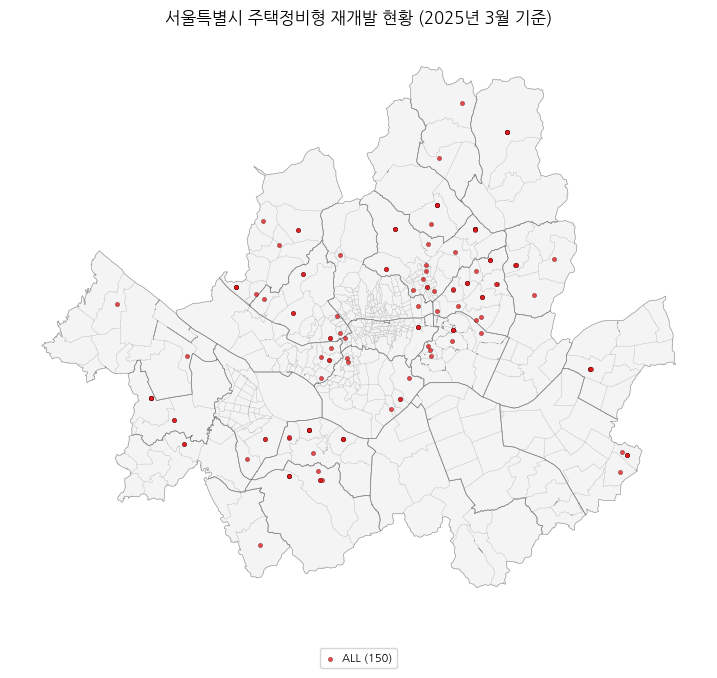

In [56]:

# 사전 조건 검사
for var in ['gdf_sgg','gdf_ok','geo_pts']:
    if var not in globals():
        raise RuntimeError(f'{var} 변수가 없습니다. 상단 셀들을 순서대로 실행하세요.')


palette = plt.cm.tab20
color_map = {c: palette(i % 20) for i, c in enumerate(order)}

fig, ax = plt.subplots(figsize=(9, 9))

# 1) 시군구 면 (연한 채움 + 진한 외곽)
gdf_sgg.plot(ax=ax, facecolor='#e0e0e0', edgecolor='black', linewidth=0.5, alpha=0.35)

# 2) 행정동 경계 (투명 채움, 얇은 회색선)
gdf_ok.plot(ax=ax, facecolor='none', edgecolor="#9A9A9A", linewidth=0.2, alpha=0.5)

# 3) 포인트 (카테고리 색상 커스텀 팔레트 적용)
custom_colors = [
    '#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00',
    '#ffff33','#a65628','#f781bf','#999999',
    '#66c2a5','#fc8d62','#8da0cb','#e78ac3'
]
color_map = {c: custom_colors[i % len(custom_colors)] for i, c in enumerate(order)}

for c in order:
    mask = (cats == c)
    pts_sub = geo_pts[mask]
    ax.scatter(
        pts_sub.geometry.x,
        pts_sub.geometry.y,
        s=10,
        c=color_map[c],
        alpha=0.8,
        marker='o',
        edgecolors='black',
        linewidths=0.2,
        zorder=3,
        label=f'{c} ({len(pts_sub)})'
    )

ax.set_title('서울특별시 주택정비형 재개발 현황 (2025년 3월 기준)', pad=12)
ax.set_axis_off()

leg = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fontsize=8,
    handlelength=1,
    columnspacing=0.8,
    handletextpad=0.6,
    labelspacing=0.4
)
if leg.get_title():
    leg.get_title().set_fontsize(9)

plt.subplots_adjust(bottom=0.12)
plt.show()

In [61]:
# 신속통합기획 값이 있는 행만 필터링 (syn_df 생성 포함)
# - 시각화 셀에서 syn_df 를 참조하므로 여기서 통일된 이름으로 변수 준비
# - '사업번호' 컬럼이 없을 경우에는 신속통합기획 강조(+) 기능을 비활성화하도록 빈 DataFrame 준비

raw_syn = pd.read_csv(csv_path)
print(f'[INFO] syn 원본 행수: {len(raw_syn)} / 컬럼 수: {len(raw_syn.columns)}')

required_flag_col = '신속통합기획'
if required_flag_col not in raw_syn.columns:
    print(f"[WARN] '{required_flag_col}' 컬럼이 없어 신속통합기획 필터링을 건너뜁니다.")
    syn_df = pd.DataFrame(columns=['사업번호', required_flag_col])
else:
    mask_present = (
        raw_syn[required_flag_col].notna() &
        raw_syn[required_flag_col].astype(str).str.strip().ne('')
    )
    syn_df = raw_syn[mask_present].copy()
    print(f"[INFO] '{required_flag_col}' 값 존재 행수: {len(syn_df)}")

syn_df

[INFO] syn 원본 행수: 150 / 컬럼 수: 40
[INFO] '신속통합기획' 값 존재 행수: 25


,사업번호,신속통합기획,자치구,법정동,운영구분,대표지번,진행단계,상태,토지등 소유자 수,정비구역명칭,...,60㎡초과~85㎡이하,85㎡초과,임대세대총수,(임대)40㎡이하,(임대)40㎡초과~50㎡이하,(임대)50㎡초과,건축계획비고,진행단계_구간,lat,lon
2,11740-900001027,1차선정구역,강동구,천호동,공공지원자,천호동 461-31,정비구역지정,운영,248,천호 A1-2구역,...,320.0,84.0,136,110.0,NaN,26.0,NaN,계획단계,37.542880,127.127337
3,11500-900001004,1차선정구역,강서구,방화동,조합,방화동 589-13,조합설립인가,운영,348,방화2구역,...,NaN,NaN,0,NaN,NaN,NaN,NaN,시행준비단계,37.576820,126.814220
10,11620-900001081,1차선정구역,관악구,신림동,공공지원자,신림동 675,정비구역지정,운영,780,신림7재정비촉진구역,...,NaN,NaN,0,NaN,NaN,NaN,NaN,계획단계,37.486897,126.928177
12,11410-900001120,1차선정구역,서대문구,홍은동,공공지원자,홍은동 8-400,정비구역지정,운영,557,홍은동 8-400 일대,...,NaN,NaN,0,NaN,NaN,NaN,NaN,계획단계,37.592960,126.937330
19,11290-900001296,1차선정구역,성북구,하월곡동,공공지원자,하월곡동 70-1,정비구역지정,운영,624,하월곡1구역 주택정비형 재개발사업,...,NaN,NaN,403,NaN,NaN,NaN,NaN,계획단계,37.604440,127.037640
22,11710-900001101,1차선정구역,송파구,마천동,추진위원회,마천동 45-,조합설립추진위원회승인,운영,1164,마천5구역 재개발정비사업,...,1145.0,230.0,408,80.0,NaN,328.0,NaN,시행준비단계,37.499747,127.148473
56,11470-900001108,1차선정구역,양천구,신월동,조합,신월동 913,조합설립인가,운영,2173,신월7동 1구역 재개발정비사업,...,435.0,NaN,581,209.0,293.0,79.0,NaN,시행준비단계,37.527820,126.836920
60,11170-900000973,1차선정구역,용산구,청파동,공공지원자,청파동1가 89-18,정비구역지정,운영,1400,청파제2구역,...,NaN,NaN,0,NaN,NaN,NaN,NaN,계획단계,37.548800,126.966680
62,11380-900001024,1차선정구역,은평구,불광동,공공지원자,불광동 600,정비구역지정,운영,0,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,계획단계,37.616065,126.933958
74,11110-900001275,1차선정구역,종로구,창신동,공공지원자,창신동 23-2,정비구역지정,운영,335,창신동 23일대 주택정비형 재개발사업,...,421.0,120.0,159,62.0,81.0,16.0,NaN,계획단계,37.575950,127.013130


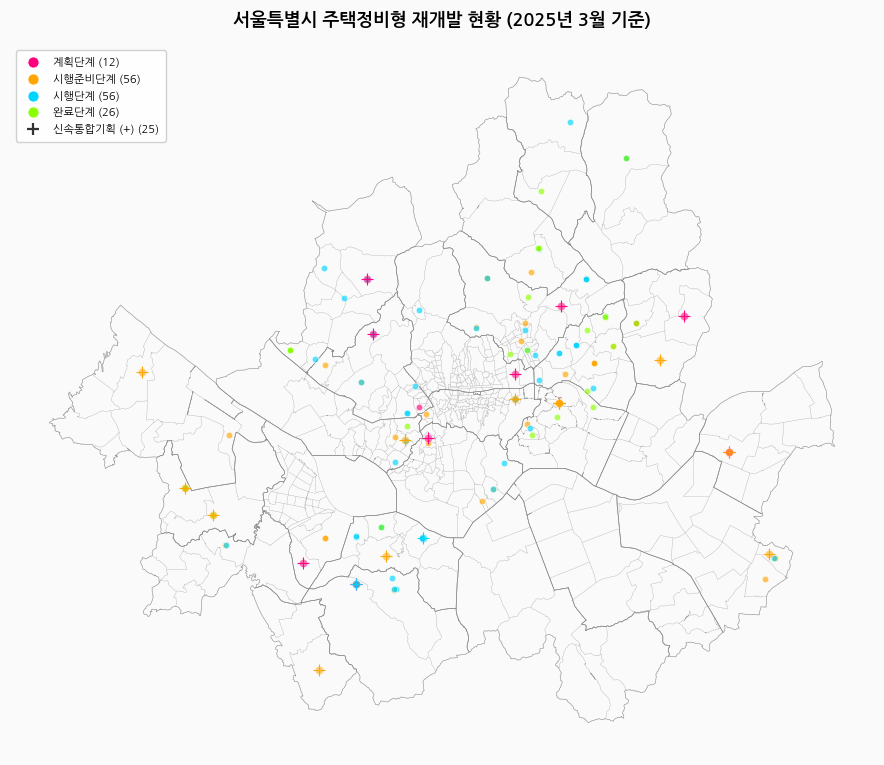

In [63]:
# 진행단계별 색상 + 신속통합기획(+) 표시 개선 버전
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import pandas as pd

stage_col = '진행단계_구간'
stage_cols = ['계획단계','시행준비단계','시행단계','완료단계']

stage_color_map = {
    '계획단계': '#ff007c',
    '시행준비단계': '#ffa600',
    '시행단계': '#00d5ff',
    '완료단계': '#8cff00',
}

ordered_stages = [s for s in stage_cols if s in stage_color_map] or list(stage_color_map.keys())

# 신속통합기획 세트: 기존 코드가 GeoDataFrame만 허용 → DataFrame 포함하도록 완화
syn_set = set()
if 'syn_df' in globals() and isinstance(syn_df, (pd.DataFrame, gpd.GeoDataFrame)):
    if '사업번호' in syn_df.columns:
        syn_set = set(syn_df['사업번호'].dropna().astype(str))

# 추가 방어: 위에서 비었으면 geo_pts 내부의 '신속통합기획' 비어있지 않은 행 사용
if not syn_set and 'geo_pts' in globals():
    if '신속통합기획' in geo_pts.columns and '사업번호' in geo_pts.columns:
        syn_set = set(geo_pts.loc[geo_pts['신속통합기획'].notna(), '사업번호'].astype(str))

if 'geo_pts' not in globals():
    raise ValueError('geo_pts 변수가 존재하지 않습니다.')

# geometry 생성
if 'geometry' not in geo_pts.columns and {'lon','lat'}.issubset(geo_pts.columns):
    from shapely.geometry import Point
    geo_pts = gpd.GeoDataFrame(
        geo_pts,
        geometry=[Point(xy) for xy in zip(geo_pts['lon'], geo_pts['lat'])],
        crs="EPSG:4326"
    )

# 단계 컬럼 준비
if stage_col not in geo_pts.columns:
    stage_plot_df = geo_pts.copy()
    stage_plot_df[stage_col] = '기타'
else:
    stage_plot_df = geo_pts.copy()

# 사업번호 문자열화
if '사업번호' not in stage_plot_df.columns:
    stage_plot_df['사업번호'] = ''
stage_plot_df['사업번호'] = stage_plot_df['사업번호'].astype(str)

fig, ax = plt.subplots(figsize=(9,9), facecolor='#fafafa')
ax.set_facecolor('#f5f5f7')

# 행정경계
if 'gdf_sgg' in globals():
    gdf_sgg.plot(ax=ax, facecolor='none', edgecolor='#555', linewidth=0.45, alpha=0.55, zorder=0)
if 'gdf_ok' in globals():
    gdf_ok.plot(ax=ax, facecolor='none', edgecolor='#999', linewidth=0.20, alpha=0.55, zorder=0)

syn_to_plot = []

for stg in ordered_stages:
    sub = stage_plot_df[stage_plot_df[stage_col] == stg]
    if sub.empty:
        continue
    color = stage_color_map.get(stg, '#666666')
    if syn_set:
        normal = sub[~sub['사업번호'].isin(syn_set)]
        syn    = sub[sub['사업번호'].isin(syn_set)]
    else:
        normal = sub
        syn = sub.iloc[0:0]

    if not normal.empty:
        ax.scatter(
            normal.geometry.x, normal.geometry.y,
            s=22, c=color, marker='o', edgecolors='white', linewidths=0.6,
            alpha=0.65, zorder=2
        )
    if not syn.empty:
        # 동심 표현(선택): 배경 원 약하게
        ax.scatter(
            syn.geometry.x, syn.geometry.y,
            s=36, c=color, marker='o', edgecolors='white', linewidths=0.6,
            alpha=0.55, zorder=4
        )
        syn_to_plot.append((syn, color))

# 신속통합기획 + 마커
for syn_sub, color in syn_to_plot:
    ax.scatter(
        syn_sub.geometry.x, syn_sub.geometry.y,
        s=70, c=color, marker='+', linewidths=0.8,
        alpha=0.95, zorder=6
    )

# 범례
stage_counts = stage_plot_df[stage_col].value_counts()
stage_handles = []
for s in ordered_stages:
    cnt = int(stage_counts.get(s, 0))
    if cnt == 0:
        continue
    stage_handles.append(
        Line2D([], [], marker='o', linestyle='', markersize=8,
               markerfacecolor=stage_color_map[s], markeredgecolor='white',
               markeredgewidth=0.6, label=f'{s} ({cnt})')
    )

# 신속통합기획 건수
if syn_set and '사업번호' in stage_plot_df.columns:
    syn_present_cnt = int(stage_plot_df['사업번호'].isin(syn_set).sum())
else:
    syn_present_cnt = 0

marker_handles = []
if syn_present_cnt > 0:
    marker_handles.append(
        Line2D([], [], marker='+', linestyle='', markersize=9,
               color='#333333', markeredgewidth=1.6,
               label=f'신속통합기획 (+) ({syn_present_cnt})')
    )

leg = ax.legend(
    handles=stage_handles + marker_handles,
    loc='upper left',
    fontsize=8,
    frameon=True,
    framealpha=0.9,
    borderpad=0.6
)
if leg.get_title():
    leg.get_title().set_fontsize(9)

ax.set_title('서울특별시 주택정비형 재개발 현황 (2025년 3월 기준)', pad=14, fontsize=13, fontweight='semibold')
ax.set_axis_off()

plt.subplots_adjust(bottom=0.12, top=0.93, left=0.02, right=0.98)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


/var/folders/v9/3b1jz93x5kj9knzc59_k8lq00000gn/T/ipykernel_59532/847769252.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/v9/3b1jz93x5kj9knzc59_k8lq00000gn/T/ipykernel_59532/847769252.py:158: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/v9/3b1jz93x5kj9knzc59_k8lq00000gn/T/ipykernel_59532/847769252.py:158: UserWarning: *c* argument looks like a single numeric RGB or RG

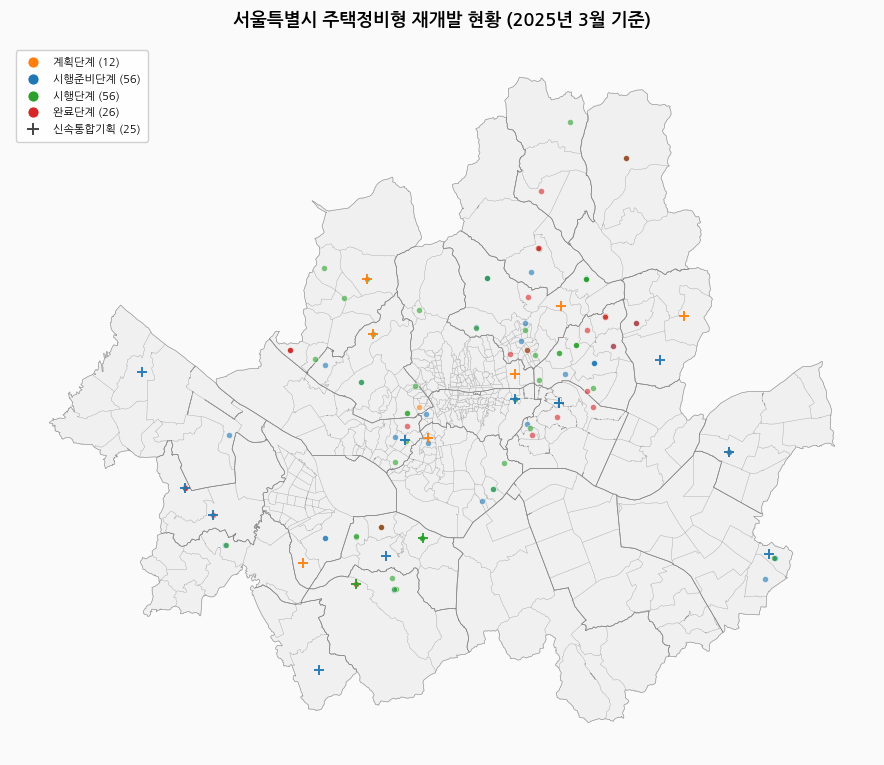

[META] {'stage_col': '진행단계_구간', 'syn_count': 25}


In [59]:
from typing import Optional, Sequence, Dict, Tuple
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import geopandas as gpd


def plot_redevelopment_stage_map(
    gdf_points: gpd.GeoDataFrame,
    gdf_admin_detail: gpd.GeoDataFrame,
    gdf_admin_group: Optional[gpd.GeoDataFrame] = None,
    syn_df: Optional[pd.DataFrame] = None,
    stage_col_candidates: Sequence[str] = ("진행단계_구간", "진행단계"),
    id_col: str = "사업번호",
    syn_flag_col: str = "신속통합기획",
    order: Optional[Sequence[str]] = ("계획단계", "시행준비단계", "시행단계", "완료단계"),
    stage_color_map: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (9, 9),
    facecolor: str = "#fafafa",
    mode: str = "scatter",  # scatter | hex
    hex_gridsize: int = 35,
    alpha_normal: float = 0.6,
    alpha_syn: float = 0.95,
    syn_marker_size: int = 55,
    normal_marker_size: int = 20,
    jitter_col: str = "jitter_applied",
    title: str = "서울특별시 주택정비형 재개발 현황 (2025년 3월 기준)",
    title_pad: int = 14,
    save_path: Optional[str] = None,
    show: bool = True,
    verbose: bool = True,
):
    """재개발 진행단계 + 신속통합기획 강조 지도.

    Parameters
    ----------
    gdf_points : GeoDataFrame
        재개발 포인트 (WGS84 권장). stage, 사업번호, jitter, syn flag 포함 가능.
    gdf_admin_detail : GeoDataFrame
        상세 행정경계(예: 읍면동). 투명 채움 경계선 표현.
    gdf_admin_group : GeoDataFrame, optional
        상위 행정경계(예: 구). 연한 채움 + 외곽선.
    syn_df : DataFrame, optional
        신속통합기획 subset (사업번호 필요). 없으면 자동 비활성.
    stage_col_candidates : list
        우선순위 기반 단계 컬럼 후보.
    id_col : str
        고유 식별 컬럼.
    syn_flag_col : str
        syn_df 미제공시 gdf_points 내에서 직접 flag 탐색 가능 (현재는 syn_df 우선).
    order : list
        범례 및 색상 순서.
    stage_color_map : dict
        단계→색상. None이면 tab10 기반 자동 생성.
    mode : str
        'scatter' | 'hex'. hex는 단계 구분 불가(집계 밀도만) → syn 표시 생략.
    save_path : str
        파일로 저장 (png/svg 등 확장자 인식). None이면 저장 안함.
    verbose : bool
        실행 로그 출력 여부.
    """
    if not isinstance(gdf_points, gpd.GeoDataFrame):
        raise TypeError("gdf_points must be a GeoDataFrame")
    if gdf_points.empty:
        raise ValueError("gdf_points is empty")

    # 1. 단계 컬럼 결정
    chosen_stage_col = None
    for c in stage_col_candidates:
        if c in gdf_points.columns:
            chosen_stage_col = c
            break
    if chosen_stage_col is None:
        if verbose:
            print(f"[WARN] No stage column found in candidates {stage_col_candidates}. Using filler '기타'.")
        chosen_stage_col = "_stage_tmp_"
        gdf_points = gdf_points.copy()
        gdf_points[chosen_stage_col] = "기타"

    # 2. syn set 준비
    syn_set = set()
    if syn_df is not None and id_col in syn_df.columns:
        syn_set = set(syn_df[id_col].dropna().astype(str))
    elif syn_flag_col in gdf_points.columns:
        # fallback: gdf_points 내 flag 컬럼 존재시 비어있지 않은 값 활용
        mask_syn = (
            gdf_points[syn_flag_col].notna() & gdf_points[syn_flag_col].astype(str).str.strip().ne("")
        )
        syn_set = set(gdf_points.loc[mask_syn, id_col].astype(str)) if id_col in gdf_points.columns else set()

    # 3. ID 문자열화
    if id_col in gdf_points.columns:
        gdf_points = gdf_points.copy()
        gdf_points[id_col] = gdf_points[id_col].astype(str)
    else:
        if verbose:
            print(f"[WARN] id_col '{id_col}' not in gdf_points → surrogate index 사용")
        gdf_points = gdf_points.copy()
        gdf_points[id_col] = gdf_points.index.astype(str)

    # 4. 색상 팔레트
    if stage_color_map is None:
        # 자동 팔레트 (tab10)
        uniq_stages = list(gdf_points[chosen_stage_col].dropna().unique())
        palette = plt.cm.tab10
        stage_color_map = {s: palette(i % 10) for i, s in enumerate(uniq_stages)}
    if order is None:
        order = list(stage_color_map.keys())

    ordered_stages = [s for s in order if s in stage_color_map]

    # 5. jitter 비율
    jitter_info = ""
    if jitter_col in gdf_points.columns:
        jr = gdf_points[jitter_col].fillna(False).mean()
        jitter_info = f" | jitter {jr:.1%} 적용"
        if verbose:
            print(f"[INFO] jitter rate: {jr:.3f}")

    # 6. 그림 설정
    fig, ax = plt.subplots(figsize=figsize, facecolor=facecolor)
    ax.set_facecolor("#f5f5f7")

    # 7. 행정 경계 레이어
    if gdf_admin_group is not None:
        gdf_admin_group.plot(
            ax=ax, facecolor="#e0e0e0", edgecolor="black", linewidth=0.5, alpha=0.35, zorder=0
        )
    gdf_admin_detail.plot(
        ax=ax, facecolor="none", edgecolor="#999", linewidth=0.25, alpha=0.55, zorder=0
    )

    # 8. 모드별 렌더링
    if mode == "hex":
        # 단순 밀도 표현 (단계 / syn 구분 없음)
        xs = gdf_points.geometry.x
        ys = gdf_points.geometry.y
        hb = ax.hexbin(xs, ys, gridsize=hex_gridsize, cmap="viridis", alpha=0.75, linewidths=0.0)
        cbar = fig.colorbar(hb, ax=ax, fraction=0.036, pad=0.02)
        cbar.set_label("Point Density")
        syn_present_cnt = sum(gdf_points[id_col].isin(syn_set)) if syn_set else 0
        if syn_present_cnt and verbose:
            print("[INFO] hex mode: syn_set 제공되었으나 개별 표시 생략")
        legend_handles = []
    else:
        # scatter 단계 + syn 오버레이
        syn_to_plot = []
        for stg in ordered_stages:
            sub = gdf_points[gdf_points[chosen_stage_col] == stg]
            if sub.empty:
                continue
            color = stage_color_map.get(stg, "#666666")
            normal = sub[~sub[id_col].isin(syn_set)] if syn_set else sub
            syn_part = sub[sub[id_col].isin(syn_set)] if syn_set else pd.DataFrame(columns=sub.columns)

            if not normal.empty:
                ax.scatter(
                    normal.geometry.x,
                    normal.geometry.y,
                    s=normal_marker_size,
                    c=color,
                    marker="o",
                    edgecolors="white",
                    linewidths=0.6,
                    alpha=alpha_normal,
                    zorder=2,
                )
            if not syn_part.empty:
                syn_to_plot.append((syn_part, color))

        for syn_sub, color in syn_to_plot:
            ax.scatter(
                syn_sub.geometry.x,
                syn_sub.geometry.y,
                s=syn_marker_size,
                c=color,
                marker="+",
                linewidths=1.4,
                alpha=alpha_syn,
                zorder=6,
            )

        # 범례 구성
        stage_counts = gdf_points[chosen_stage_col].value_counts()
        legend_handles = []
        for s in ordered_stages:
            cnt = int(stage_counts.get(s, 0))
            if cnt == 0:
                continue
            legend_handles.append(
                Line2D(
                    [],
                    [],
                    marker="o",
                    linestyle="",
                    markersize=8,
                    markerfacecolor=stage_color_map[s],
                    markeredgecolor="white",
                    markeredgewidth=0.6,
                    label=f"{s} ({cnt})",
                )
            )

        syn_present_cnt = (
            int(gdf_points[id_col].isin(syn_set).sum()) if syn_set else 0
        )
        if syn_present_cnt:
            legend_handles.append(
                Line2D(
                    [],
                    [],
                    marker="+",
                    linestyle="",
                    markersize=9,
                    color="#444444",
                    markeredgewidth=1.4,
                    label=f"신속통합기획 ({syn_present_cnt})",
                )
            )

    # 9. 타이틀 & 레이아웃
    ax.set_title(
        f"{title}{jitter_info}", pad=title_pad, fontsize=13, fontweight="semibold"
    )
    ax.set_axis_off()

    if legend_handles:
        leg = ax.legend(
            handles=legend_handles,
            loc="upper left",
            fontsize=8,
            frameon=True,
            framealpha=0.9,
            borderpad=0.6,
        )
        if leg.get_title():
            leg.get_title().set_fontsize(9)

    plt.subplots_adjust(bottom=0.12, top=0.93, left=0.02, right=0.98)
    for spine in ax.spines.values():
        spine.set_visible(False)

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
        if verbose:
            print(f"[SAVE] saved figure to {save_path}")

    if show:
        plt.show()

    return fig, ax, {"stage_col": chosen_stage_col, "syn_count": len(syn_set)}


# === 예시 실행 ===
try:
    fig, ax, meta = plot_redevelopment_stage_map(
        gdf_points=geo_pts,
        gdf_admin_detail=gdf_ok,
        gdf_admin_group=gdf_sgg if 'gdf_sgg' in globals() else None,
        syn_df=syn_df if 'syn_df' in globals() else None,
        mode='scatter',
        save_path=None,  # 예: 'outputs/stage_syn_map.png'
    )
    print('[META]', meta)
except Exception as e:
    print('[ERROR] plotting function failed:', e)

### ✅ 진행단계 + 신속통합기획 통합 시각화 (Reusable Function)
이전 셀 코드는 1회성 절차형 구현입니다. 아래 셀에서 재사용 가능한 함수로 일반화하여:

- 자동 단계 컬럼 감지(`진행단계_구간` → fallback: `진행단계` → 없으면 임시 `기타`)
- 사용자 지정 색상 팔레트 / 자동 생성
- 신속통합기획 강조: `+` 마커 (존재하지 않으면 자동 비활성)
- jitter 적용률 표기(`jitter_applied` 존재 시)
- 점 밀도 높을 때 대안 모드(`mode='scatter' | 'hex' | 'kde'`)
- 반환 객체(fig, ax)로 추가 애노테이션/저장 확장 용이
- 저장 옵션(save_path)

추가 아이디어 (향후):
- 마커 hover(Tooltip) → mplcursors / plotly 변환
- 단계 누락값 비율 경고 출력
- syn_df 없이 특정 키워드(예: '신속') 포함 텍스트 탐지 fallback

아래 함수 정의 후 바로 실사용 예시를 실행합니다.

In [60]:
# 진행단계 컬럼 감사(Audit) & 진단 리포트
# 목적: 왜 특정 DB(또는 syn_df 필터 결과)에 '진행단계' 또는 '진행단계_구간'이 없다고 인식되는지 즉시 점검
# 1) 컬럼 존재 여부
# 2) Null / 공백 비율
# 3) 고유값 리스트 (상위 N)
# 4) 원본(df_geo) vs 필터(syn_df) 비교
# 5) 잠재적 컬럼명 변형 패턴(공백/유니코드 정규화)

import unicodedata as ucd
import pandas as pd

TARGET_COL_BASE = '진행단계'
ALT_COL = '진행단계_구간'

frames = []
if 'df_geo' in globals():
    frames.append(('원본전체(df_geo)', df_geo))
if 'syn_df' in globals():
    frames.append(('신속통합(syn_df)', syn_df))

if not frames:
    raise SystemExit('[AUDIT] 점검할 DataFrame 이 없습니다. 상단 셀 실행 필요.')

report_rows = []

def col_stats(label, df: pd.DataFrame, col_name: str):
    if col_name not in df.columns:
        return {'exists': False}
    ser = df[col_name]
    null_ratio = ser.isna().mean()
    blank_ratio = ser.astype(str).str.strip().eq('').mean()
    uniques = ser.astype(str).str.strip().unique()
    return {
        'exists': True,
        'null_ratio': round(float(null_ratio),4),
        'blank_ratio': round(float(blank_ratio),4),
        'n_unique': len(uniques),
        'sample_uniques': list(uniques[:10])
    }

def possible_renamed(df: pd.DataFrame, target: str):
    # 공백 제거, NFKC 정규화하여 타겟과 유사한 이름이 있는지
    norm_target = ucd.normalize('NFKC', target).replace(' ','')
    candidates = []
    for c in df.columns:
        norm_c = ucd.normalize('NFKC', c).replace(' ','')
        if norm_c == norm_target and c != target:
            candidates.append(c)
    return candidates

for label, df in frames:
    base_stats = col_stats(label, df, TARGET_COL_BASE)
    alt_stats = col_stats(label, df, ALT_COL)
    alt_names = possible_renamed(df, TARGET_COL_BASE)
    report_rows.append({
        'Dataset': label,
        'col_base_exists': base_stats.get('exists', False),
        'col_alt_exists': alt_stats.get('exists', False),
        'base_null_ratio': base_stats.get('null_ratio'),
        'base_blank_ratio': base_stats.get('blank_ratio'),
        'alt_null_ratio': alt_stats.get('null_ratio'),
        'alt_blank_ratio': alt_stats.get('blank_ratio'),
        'base_n_unique': base_stats.get('n_unique'),
        'alt_n_unique': alt_stats.get('n_unique'),
        'base_sample_uniques': base_stats.get('sample_uniques'),
        'alt_sample_uniques': alt_stats.get('sample_uniques'),
        'possible_renamed': alt_names,
        'row_count': len(df)
    })

audit_df = pd.DataFrame(report_rows)
print('[AUDIT] 진행단계 관련 컬럼 점검 요약:')
display(audit_df)

# 상세 샘플 (첫 DataFrame 기준)
first_label, first_df = frames[0]
print(f"[AUDIT] '{first_label}' 상위 5행 (진행단계 관련 컬럼만):")
cols_show = [c for c in [TARGET_COL_BASE, ALT_COL] if c in first_df.columns]
if cols_show:
    display(first_df[cols_show].head())
else:
    print(' - 진행단계 컬럼들이 전혀 존재하지 않습니다.')

# 차이 비교 (두 DataFrame 모두 존재할 때)
if len(frames) == 2 and all(TARGET_COL_BASE in f[1].columns for f in frames):
    s_all = set(frames[0][1][TARGET_COL_BASE].astype(str).str.strip())
    s_syn = set(frames[1][1][TARGET_COL_BASE].astype(str).str.strip())
    missing_in_syn = s_all - s_syn
    if missing_in_syn:
        print(f'[AUDIT] syn_df 에서 누락된 진행단계 값 종류 수: {len(missing_in_syn)} 예시: {list(missing_in_syn)[:8]}')
    else:
        print('[AUDIT] syn_df 진행단계 값은 원본 df_geo 집합을 모두 포함합니다.')

print('[AUDIT] 완료')

[AUDIT] 진행단계 관련 컬럼 점검 요약:


,Dataset,col_base_exists,col_alt_exists,base_null_ratio,base_blank_ratio,alt_null_ratio,alt_blank_ratio,base_n_unique,alt_n_unique,base_sample_uniques,alt_sample_uniques,possible_renamed,row_count
0,원본전체(df_geo),True,True,0.0,0.0,0.0,0.0,10,4,"[조합설립인가, 정비구역지정, 관리처분인가, 일반분양승인, 이전고시, 조합설립추진위...","[시행준비단계, 계획단계, 시행단계, 완료단계]",[],150
1,신속통합(syn_df),True,True,0.0,0.0,0.0,0.0,5,3,"[정비구역지정, 조합설립인가, 조합설립추진위원회승인, 사업시행인가, 철거신고]","[계획단계, 시행준비단계, 시행단계]",[],25


[AUDIT] '원본전체(df_geo)' 상위 5행 (진행단계 관련 컬럼만):


,진행단계,진행단계_구간
0,조합설립인가,시행준비단계
1,조합설립인가,시행준비단계
2,정비구역지정,계획단계
3,조합설립인가,시행준비단계
4,조합설립인가,시행준비단계


[AUDIT] syn_df 에서 누락된 진행단계 값 종류 수: 5 예시: ['이전고시', '준공인가', '착공신고', '관리처분인가', '일반분양승인']
[AUDIT] 완료
